In [ ]:
pip install rocketpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 KB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 87.8 MB/s eta 0:00:00
  Created wheel for simplekml: filename=simplekml-1.3.6-py3-none-any.whl size=65875 sha256=6e200e6c24930cbe4c1d8213dbe56241590c2933c576a393a7b06495cdae0b8e
  Stored in directory: /root/.cache/pip/wheels/61/7c/b1/a15afd1959498020ff45abc6e309b5c48975a5d741e60c5922
Successfully built simplekml
  Attempting uninstall: netCDF4
    Found existing installation: netCDF4 1.6.2
    Uninstalling netCDF4-1.6.2:
      Successfully uninstalled netCDF4-1.6.2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from rocketpy import Environment,Rocket,SolidMotor,Flight
from scipy.integrate import simpson
from mpl_toolkits import mplot3d
import csv
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
wind_speed =  3 # m/s. This will be constant for the analysis
lower_button_list = list((np.arange(-2,0,.2)))
lower_button_list.reverse()
print(lower_button_list)
upper_button_list = list((np.arange(0,2,.2)))
print(upper_button_list)

Env = Environment(railLength=3.66, latitude=35.176307, longitude=-76.826296, elevation=10)

Env.setAtmosphericModel(type="CustomAtmosphere", wind_v=wind_speed)

# Prepare Motor
L1520T = SolidMotor(
    thrustSource="AeroTech_L1520T.eng",
    burnOut=2.4,
    grainNumber=3,
    grainSeparation= 0.0016,
    grainDensity= 1625,
    grainOuterRadius= 0.031661,
    grainInitialInnerRadius= 0.011112,
    grainInitialHeight= 0.1318,
    nozzleRadius= 0.023813,
    throatRadius= 0.0086995,
    interpolationMethod="linear",
)

# Prepare Rocket
FullScale = Rocket(
    motor=L1520T,
    radius=0.07835,
    mass= 16.27,
    inertiaI=9.618,
    inertiaZ=0.04,
    distanceRocketNozzle=-1.277,
    distanceRocketPropellant=-0.759,
    powerOffDrag="OR_power_off_validated.csv",
    powerOnDrag="OR_power_off_validated.csv",
)

NoseCone = FullScale.addNose(length=.782, kind="ogive", distanceToCM=0.61)

FinSet = FullScale.addTrapezoidalFins(
    n=4,
    rootChord=0.25,
    tipChord=0.157,
    span=0.15,
    distanceToCM=-0.871,
    cantAngle=0,
    radius=None,
    airfoil=None,
)

Tail = FullScale.addTail(
    topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
)

[-0.2000000000000004, -0.40000000000000036, -0.6000000000000003, -0.8000000000000003, -1.0000000000000002, -1.2000000000000002, -1.4000000000000001, -1.6, -1.8, -2.0]
[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.2000000000000002, 1.4000000000000001, 1.6, 1.8]


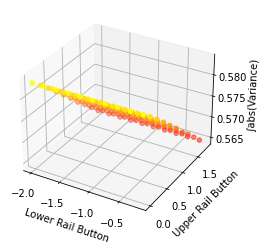

In [ ]:
lower_button_plot = []
upper_button_plot = []
integral = []
# Simulate first 5 seconds of Flight
for i in lower_button_list:
    for j in upper_button_list:
        FullScale.setRailButtons([i, j])

        TestFlight = Flight(
            rocket=FullScale,
            environment=Env,
            inclination=90,
            heading=0,
            maxTimeStep=0.01,
            maxTime=5,
        )
        try:
            TestFlight.postProcess()

            # Perform a Fourier Analysis
            Fs = 100.0
            # sampling rate
            Ts = 1.0 / Fs
            # sampling interval
            t = np.arange(1, 5, Ts)  # time vector
            ff = 5
            # frequency of the signal
            y = TestFlight.attitudeAngle(t) - np.mean(TestFlight.attitudeAngle(t))



            coef = np.polyfit(t,y,1)
            y_new = np.polyval(coef,t)

            y_int = simpson(abs(y-y_new),dx=0.01)
            lower_button_plot.append(i)
            upper_button_plot.append(j)
            integral.append(y_int)
            #print(y_int)
            #print(i)
            #print(j)
        except: # some are saying divide by zero for some reason
            continue

#fig = plt.plot(t,y-y_new)
#plt.show()

ax = plt.axes(projection='3d')
ax.scatter3D(lower_button_plot, upper_button_plot, integral, c=integral, cmap='autumn')
ax.set_xlabel('Lower Rail Button')
ax.set_ylabel('Upper Rail Button')
ax.set_zlabel('∫abs(Variance)')
plt.show()



In [ ]:
# DATA OUTPUT IN FOLDER
data = [lower_button_plot, upper_button_plot, integral]
with open('AmplitudeIntegral.csv', 'w', newline='') as file:
     writer = csv.writer(file)

     # Write the list of lists to the CSV file
     writer.writerows(data)